In [1]:
in_path = "../data/interim/"
out_path = "../data/processed/data_master.pkl"

In [2]:
from os.path import dirname
import os, sys, inspect

currentdir = os.getcwd()
parentdir = dirname(currentdir)

sys.path.insert(0,parentdir)

# Libs

In [3]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 

from src.utils import dump_to_pickle, change_major_detector
from src.visualize import plot_compare_dist, plot_compare_categorical

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Load Data

In [4]:
OPCS_master = pd.read_pickle(in_path+'OPCS_master.pkl')
OA_master = pd.read_pickle(in_path+'OA_master.pkl')
HS_master = pd.read_pickle(in_path+'HS_master.pkl')

In [5]:
OPCS_used = OPCS_master[['NIM', 'form_number', 'major_code_opcs', 'major_name_opcs', 'Last_CGPA']]

### Merge OA - OPCS - HS

In [6]:
data = pd.merge(OPCS_used, HS_master, on='NIM', how='inner')
data = data.merge(OA_master, on='form_number', how='inner')

In [7]:
curr_filtered = ['Social', 'Science']
data = data.loc[data.curriculum_name.isin(curr_filtered)]

In [8]:
data.shape

(2101, 22)

In [9]:
data.head()

,NIM,form_number,major_code_opcs,major_name_opcs,Last_CGPA,ENG,MATH,BIO,CHEM,PHY,ECON,GEO,SOC,FINAL,major_code_oa,major_name_oa,gender,school_prop,school_name,school_state,school_geo_unit,curriculum_name
0,01011180001,1831100382,01011,Manajemen,3.25,73.25,70.75,NaN,NaN,NaN,86.50,73.75,79.25,30.80,01011,Manajemen,Female,SMA,SMAN 1 SIDIKALANG,SUMUT,SUM,Social
1,01011180002,1811100709,01011,Manajemen,1.06,77.75,64.75,NaN,NaN,NaN,79.25,80.00,76.25,25.95,01011,Manajemen,Male,SMA,SMA Islam Al-Azhar 8 Bekasi,JABAR,JAV,Social
2,01011180003,1811100388,01011,Manajemen,2.07,70.25,66.75,NaN,NaN,NaN,79.50,77.50,82.25,27.40,01011,Manajemen,Male,SMA,SMA Katolik St. Peter,NTT,SUN,Social
3,01011180004,1831100016,01011,Manajemen,2.91,82.25,85.00,NaN,NaN,NaN,71.75,77.75,72.75,28.40,01011,Manajemen,Male,SMA,SMA El Shadai Magelang,JATENG,JAV,Social
4,01011180005,1811100684,01011,Manajemen,3.28,85.25,78.00,80.25,75.5,78.5,NaN,NaN,NaN,33.90,01011,Manajemen,Male,SMK,SMK Eran Batu 2,SULSEL,SUL,Science


# Handling Missing Values

In [10]:
data.isnull().sum()

NIM                   0
form_number           0
major_code_opcs       0
major_name_opcs       0
Last_CGPA             0
ENG                   4
MATH                  4
BIO                1011
CHEM               1011
PHY                1011
ECON               1093
GEO                1093
SOC                1093
FINAL                 0
major_code_oa         0
major_name_oa         0
gender                0
school_prop          99
school_name          99
school_state         99
school_geo_unit      99
curriculum_name       0
dtype: int64

##### Impute Missing Subjects Features

In [11]:
#impute subject score with 0
subj_cols = [
    'BIO', 'CHEM', 'ECON', 'ENG',
    'GEO', 'MATH', 'PHY', 'SOC'
]

In [12]:
for col in subj_cols:
    data[col] = data[col].fillna(0)

##### Impute Missing School Features

In [13]:
#impute prop and state with mode
school_cols = ['school_prop', 'school_state']

In [14]:
for col in school_cols:
    data[col] = data[col].fillna(data[col].mode()[0])

In [15]:
#impute geo_unit based on state

dict_reg = {
    'JAV': ['DIY', 'DKIJKT', 'BANTEN', 'JATENG',  'JABAR', 'JATIM'],
    'SUM': ['SUMUT', 'SUMBAR', 'ACEH', 'LAMPUN', 'SUMSEL', 'RIAU', 'BENGKU', 'JAMBI', 'BANGKA', 'PEKANB'],
    'KAL': ['KALBAR', 'KALTGH', 'KALSEL', 'KALUT', 'KALTIM'],
    'SUL': ['SULSEL', 'SULBAR', 'SULUT', 'SULTGH', 'SULTGR', 'GORONT'],
    'SUN': ['NTT', 'NTB', 'BALI'],
    'MAL': ['MALUKU', 'MALUTA'],
    'PAP': ['PAPBRT', 'PAPUA'],
    'LN': ['LN']
}

In [16]:
for geo_unit, state in dict_reg.items():
    data.loc[data.school_state.isin(state), 'school_geo_unit'] = geo_unit

In [17]:
data.isnull().sum()

NIM                 0
form_number         0
major_code_opcs     0
major_name_opcs     0
Last_CGPA           0
ENG                 0
MATH                0
BIO                 0
CHEM                0
PHY                 0
ECON                0
GEO                 0
SOC                 0
FINAL               0
major_code_oa       0
major_name_oa       0
gender              0
school_prop         0
school_name        99
school_state        0
school_geo_unit     0
curriculum_name     0
dtype: int64

# Label Definition

In [18]:
data['fail'] = data['Last_CGPA'].apply(lambda x: 1 if x<2 else 0)

# EDA + Feature Extraction

#### Class Size

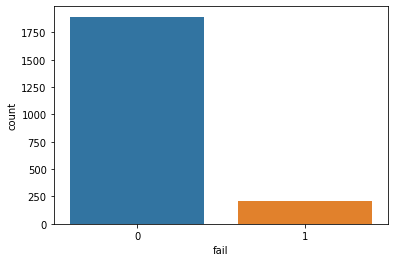

In [19]:
sns.countplot(data.fail)

In [20]:
data.fail.value_counts()

0    1893
1     208
Name: fail, dtype: int64

#### Last_CGPA Distribution

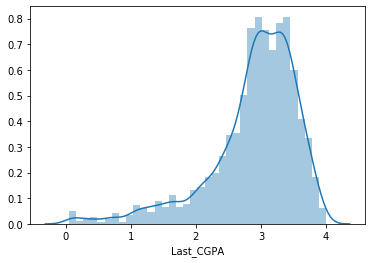

In [21]:
sns.distplot(data['Last_CGPA'])

#### HS Scores Distribution

In [22]:
hs_scores_feat = data.select_dtypes(include='float64').drop('Last_CGPA', axis=1).columns.values

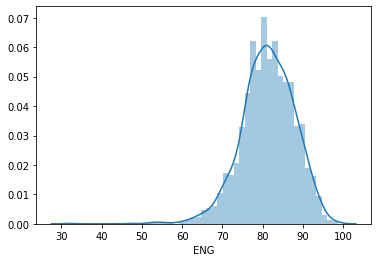

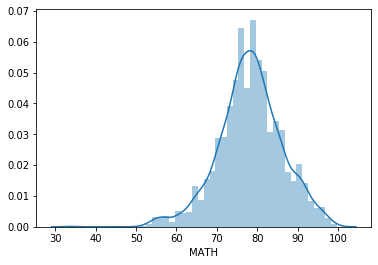

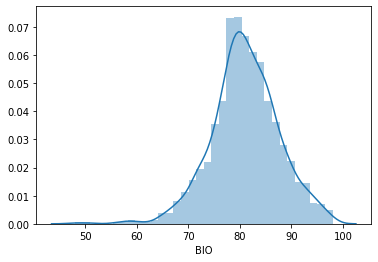

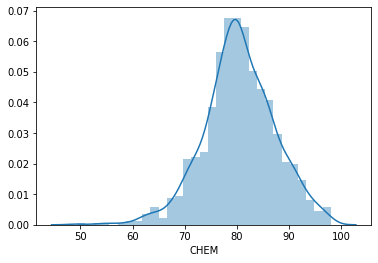

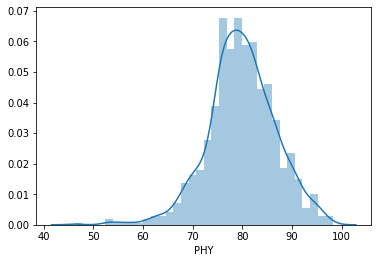

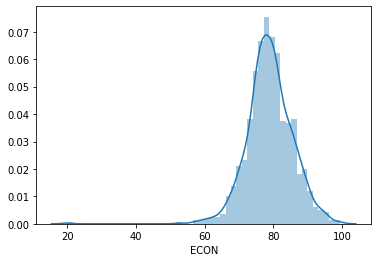

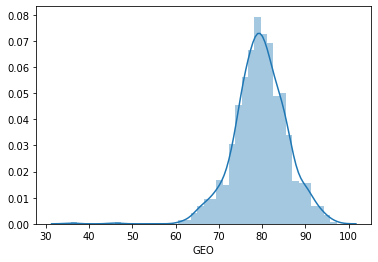

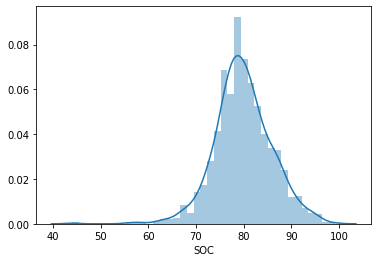

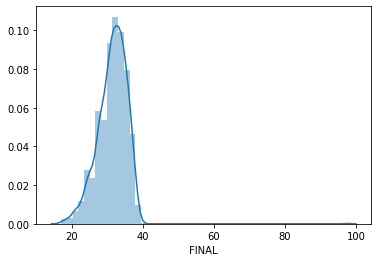

In [23]:
for col in hs_scores_feat:
    sns.distplot(data[data[col]!=0][col])
    plt.show()

### Flag Changed Major
compare major name in admission form and in OPCS, if different then assume to change major during first year period

In [24]:
data['has_changed_major'] = \
data.apply(lambda row: change_major_detector(row['major_code_oa'], row['major_code_opcs']),
          axis=1)

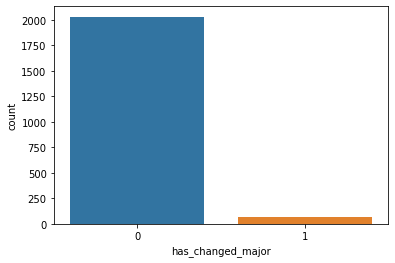

In [25]:
sns.countplot(data.has_changed_major)

In [26]:
data['has_changed_major'].value_counts()

0    2029
1      72
Name: has_changed_major, dtype: int64

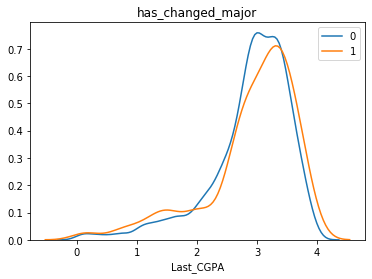

In [27]:
disc_feat = 'has_changed_major'
cont_feat = 'Last_CGPA'

plot_compare_dist(data, disc_feat, cont_feat)

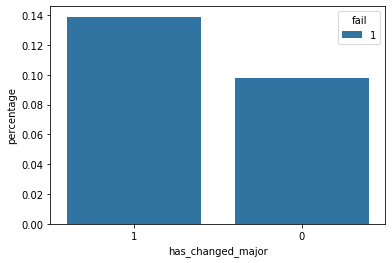

In [28]:
feature = "has_changed_major"
target = "fail"

plot_compare_categorical(data, feature, target)

#### Major

In [29]:
major_cnt = data.major_name_opcs.value_counts()

Text(0.5, 1.0, 'Major Count')

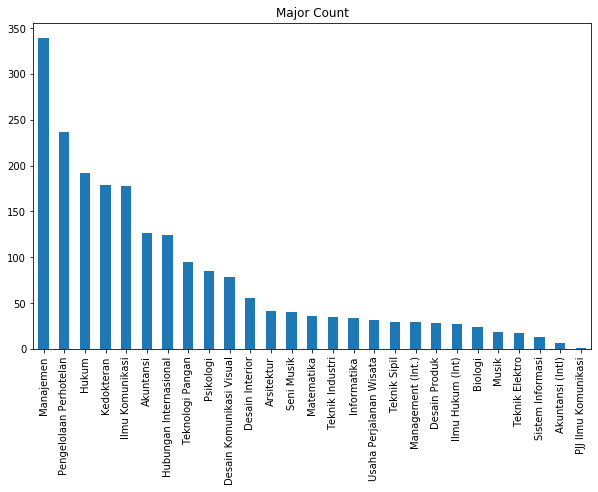

In [30]:
plt.figure(figsize=(10,6))
major_cnt.plot.bar()
plt.title('Major Count')

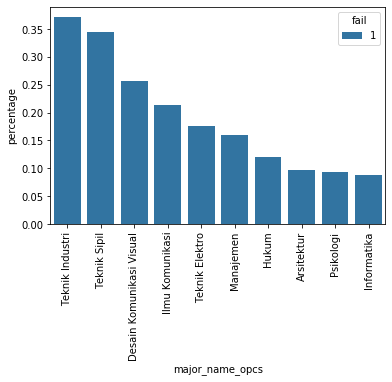

In [31]:
feature = "major_name_opcs"
target = "fail"

plot_compare_categorical(data, feature, target, top_n=10, rotation=90)

### Grouping Major to Faculty

In [32]:
dict_faculty = {
    'BS' : ['Manajemen', 'Akuntansi', 'Management (Int.)', 'Akuntansi (Intl)'],
    
    'SOD' : ['Arsitektur', 'Desain Komunikasi Visual', 'Desain Interior', 'Desain Produk'],
    
    'FaST' : ['Teknik Sipil', 'Teknik Elektro', 'Teknik Industri', 
                   'Teknologi Pangan', 'Matematika', 'Biologi'],
    
    'FISIP' : ['Ilmu Komunikasi', 'Hubungan Internasional', 'PJJ Ilmu Komunikasi'],
    
    'Law' : ['Hukum', 'Ilmu Hukum (Int)'],
    
    'CoM' : ['Seni Musik', 'Musik'],
    
    'Medicine' : ['Kedokteran'],
    
    'FIK' : ['Sistem Informasi', 'Informatika'],
    
    'Psy' : ['Psikologi'],
    
    'STPPH' : ['Pengelolaan Perhotelan', 'Usaha Perjalanan Wisata']
}

In [33]:
data['faculty'] = None
for faculty, major in dict_faculty.items():
    data.loc[data.major_name_opcs.isin(major), 'faculty'] = faculty

Text(0.5, 1.0, 'Faculty Count')

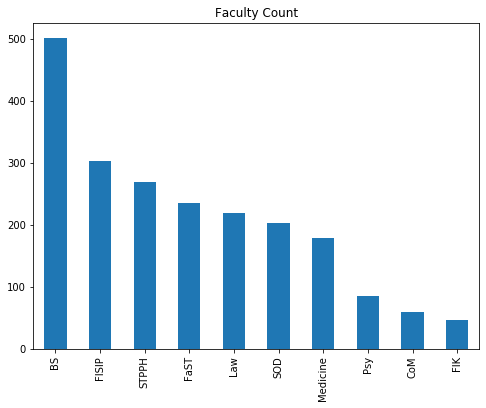

In [34]:
fac_cnt = data.faculty.value_counts()

plt.figure(figsize=(8,6))
fac_cnt.plot.bar()
plt.title('Faculty Count')

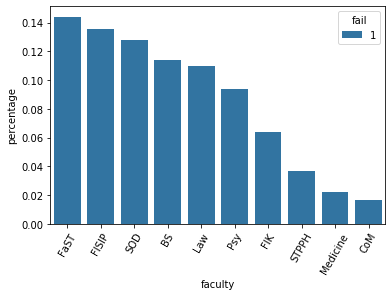

In [35]:
feature = "faculty"
target = "fail"

plot_compare_categorical(data, feature, target, top_n=10, rotation=60)

#### Curriculum

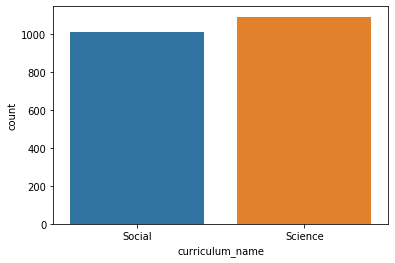

In [36]:
sns.countplot(data.curriculum_name)

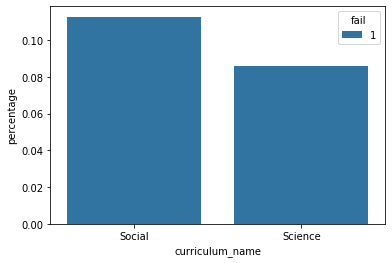

In [37]:
feature = "curriculum_name"
target = "fail"

plot_compare_categorical(data, feature, target)

# Dump to Pickle

In [38]:
dump_to_pickle(data, out_path)